In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

2024-09-25 15:35:06.305040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 15:35:07.587613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-25 15:35:07.587937: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-25 15:35:07.587949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
df=pd.read_csv("data/Dataset_unsupervised.csv")
df.head(5)

,Command,Camera
0,Follow the person in front of you.,1
1,Detect any obstacles and avoid them.,1
2,Scan the area for moving objects.,1
3,Identify the red car below and hover above it.,1
4,Track the object moving to the right.,1


In [35]:
df.groupby('Camera').describe()

Command                                                             
         count unique                                              top freq
Camera                                                                     
0          824    588        Return to base and perform a system check   13
1         1420    972  Capture image of the landing site after landing   11

In [36]:
df_nocam = df[df['Camera']==0]
df_nocam.shape

(824, 2)

In [37]:
df_cam = df[df['Camera']==1]
df_cam.shape

(1420, 2)

In [38]:
df_cam_downsampled = df_cam.sample(df_nocam.shape[0])
df_cam_downsampled.shape

(824, 2)

In [39]:
df_balanced = pd.concat([df_cam_downsampled, df_nocam])
df_balanced.shape

(1648, 2)

In [41]:
df=df_balanced
df.groupby('Camera').describe()

Command                                                         
         count unique                                          top freq
Camera                                                                 
0          824    588    Return to base and perform a system check   13
1          824    640  Fly over the area and assess the situation.   11

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Command'],df['Camera'], stratify=df['Camera'], test_size=0.1)

In [43]:
print(len(X_test))
X_train.head(4)


165


1804                         Adjust the camera zoom to 5x
1839                 Hover at 10 meters and inspect cargo
1782    Obtain a high-resolution image of the surround...
1519    Fly to the designated location and begin data ...
Name: Command, dtype: object

In [44]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2024-09-22 17:38:40.470803: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 93763584 exceeds 10% of free system memory.


**Model Type 1**

In [45]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

**Model Type 2**

In [38]:
# BERT layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="the_college_dropout")(outputs['pooled_output'])

# Adding multiple hidden layers
l = tf.keras.layers.Dense(128, activation='relu', name="hidden_layer_1")(l)
l = tf.keras.layers.Dropout(0.2)(l)
l = tf.keras.layers.Dense(64, activation='relu', name="hidden_layer_2")(l)
l = tf.keras.layers.Dropout(0.2)(l)
l = tf.keras.layers.Dense(32, activation='relu', name="hidden_layer_3")(l)

# Output layer
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs=[output])


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [46]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [47]:
len(X_train)

1483

In [48]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [50]:
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
47/47 [==============================] - 139s 3s/step - loss: 0.6959 - accuracy: 0.5536 - precision: 0.5502 - recall: 0.5843
Epoch 2/20
47/47 [==============================] - 139s 3s/step - loss: 0.6571 - accuracy: 0.6069 - precision: 0.6129 - recall: 0.5789
Epoch 3/20
47/47 [==============================] - 140s 3s/step - loss: 0.6337 - accuracy: 0.6170 - precision: 0.6110 - recall: 0.6424
Epoch 4/20
47/47 [==============================] - 139s 3s/step - loss: 0.6316 - accuracy: 0.6365 - precision: 0.6369 - recall: 0.6343
Epoch 5/20
47/47 [==============================] - 137s 3s/step - loss: 0.6136 - accuracy: 0.6655 - precision: 0.6658 - recall: 0.6640
Epoch 6/20
47/47 [==============================] - 131s 3s/step - loss: 0.6010 - accuracy: 0.6784 - precision: 0.6714 - recall: 0.6977
Epoch 7/20
47/47 [==============================] - 134s 3s/step - loss: 0.5933 - accuracy: 0.6966 - precision: 0.6964 - recall: 0.6964
Epoch 8/20
47/47 [==============================

In [51]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 16s 2s/step - loss: 0.4917 - accuracy: 0.7939 - precision: 0.8769 - recall: 0.6867


[0.49171197414398193,
 0.7939394116401672,
 0.8769230842590332,
 0.6867470145225525]

In [60]:
test = ["move the drone 10 m", "move towards the edible object"]
prediction = model.predict(test)
prediction

1/1 [==============================] - 0s 233ms/step


array([[0.318452  ],
       [0.34977323]], dtype=float32)

In [53]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

6/6 [==============================] - 16s 2s/step


In [56]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1])

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[74,  8],
       [26, 57]])

Text(50.722222222222214, 0.5, 'Truth')

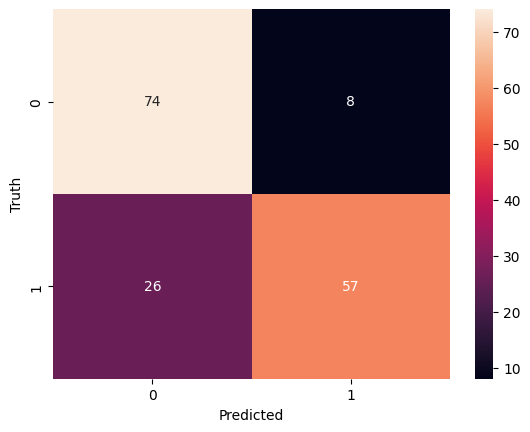

In [58]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [59]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81        82
           1       0.88      0.69      0.77        83

    accuracy                           0.79       165
   macro avg       0.81      0.79      0.79       165
weighted avg       0.81      0.79      0.79       165

